### Additional Numerical error experiments

The code has not been completely cleaned up by lack of time.

We include it for people who want to digg deeper on advanced aspects of the numerical eror analasys.

As an excuse for the code not being completely cleaned up, 
I have to say that the review of our paper took over two years, just to get the first round of review.
Hence it was difficult to get back in the code after such a long time.

However, if you are interested in this analysis, please let us know and we will do our best to clarify/clean up further

In [1]:
from itertools import chain
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("dark_background")

In [2]:
units = {"MiB":lambda x:x//2**20,
         None:lambda x:x}

distrib = {"normal"  : torch.randn,
           "uniform" : torch.rand}

def input_factory(bs=64, ch=64, dims=(128, 128), mu=0, sigma=1, dist="normal"):
    return ((distrib[dist]((bs, ch) + tuple(dims))*sigma) + mu).cuda()

def iskip_factory(c, nlayers, nskip, skip_invert=True, invert=True, bn_ieps=0.1, negative_slope=0.5):
    residual_module_fn = lambda x: iconv_blok_factory(x, nlayers)
    skip = nn.Sequential(*[ISkip(c, residual_module_fn, skip_invert=skip_invert, invert=invert) for n in range(nskip)])
    return skip

def iconv_factory(c=64, nlayers=5, invert=True):
    mod = nn.Sequential(*[IConv2d(c, c, kernel_size=3, stride=1, padding=1, bias=False, invert=invert) for n in range(nlayers)]).cuda()
    setattr(mod, "invert", invert)
    return mod
    
def iconv_blok_factory(c=64, nlayers=5, neg_slope=.5, ieps=.1, invert=True):
    mod =  nn.Sequential(*chain(*[(
                IConv2d(c, c, kernel_size=3, stride=1, padding=1, bias=False, invert=invert),
                 IBatchNorm2d(c, ieps=ieps),#)
     #           ILeakyReLU(negative_slope=neg_slope) 
    )
      for n in range(nlayers)])
                ).cuda()
    setattr(mod, "invert", invert)
    return mod

def iconv_leaky_factory(c=64, nlayers=5, neg_slope=.5, invert=True):
    mod =  nn.Sequential(*chain(*[(
                ILeakyReLU(negative_slope=neg_slope),
                IConv2d(c, c, kernel_size=3, stride=1, padding=1, bias=False, invert=invert),
    ) for n in range(nlayers)])).cuda()
    
    setattr(mod, "invert", invert)
    return mod

def get_bn_weight(mod):
    return list(map(lambda x:x.weight.data, filter(lambda x:isinstance(x, IBatchNorm2d), mod.modules())))

def init_bn_weight(mod, fact=1, nch=1):
    for i, weight in enumerate(get_bn_weight(mod)):
        ww = torch.ones_like(weight)
        perm = torch.randperm(100)
        ww[perm<=nch] = ww[perm<=nch]/fact
        weight.set_(ww)
        
f={
    "snr"    : lambda x: (x[0].std()**2/(x[0]-x[1]).std()**2).item(),
    "snr_"    : lambda x: ((x[1].var() - (x[0]-x[1]).var())/(x[0]-x[1]).std()**2).item(),
    "foo"    : lambda x: (x[0].std()/(x[0]-x[1]).std()).item(),
    "logsnr" : lambda x: 2*(torch.log10(x[0].std()) - torch.log10((x[0]-x[1]).std())).item(),
    "logfoo" : lambda x: 2*(torch.log10(x[0].std()) - torch.log10((x[0]-x[1]).std())).item(),
}
f_= f.keys()

In [3]:
ch  = 100
dim = 10
eps = 10**-8
eps_= 0
nlayer = 15
bs = 100
sigma = 1
mu = 0

invert = False 
neg_slope=.01
ieps = 0.001

# Leaky ReLU - Low noise regime

In [9]:
f={
    "snr" : lambda x: ((x[0]**2).mean()/((x[0]-x[1])**2).mean()).item(),
}

alpha = lambda phi: 4*((1 + phi**2) * (1 + 1/(phi**2)) )**-1

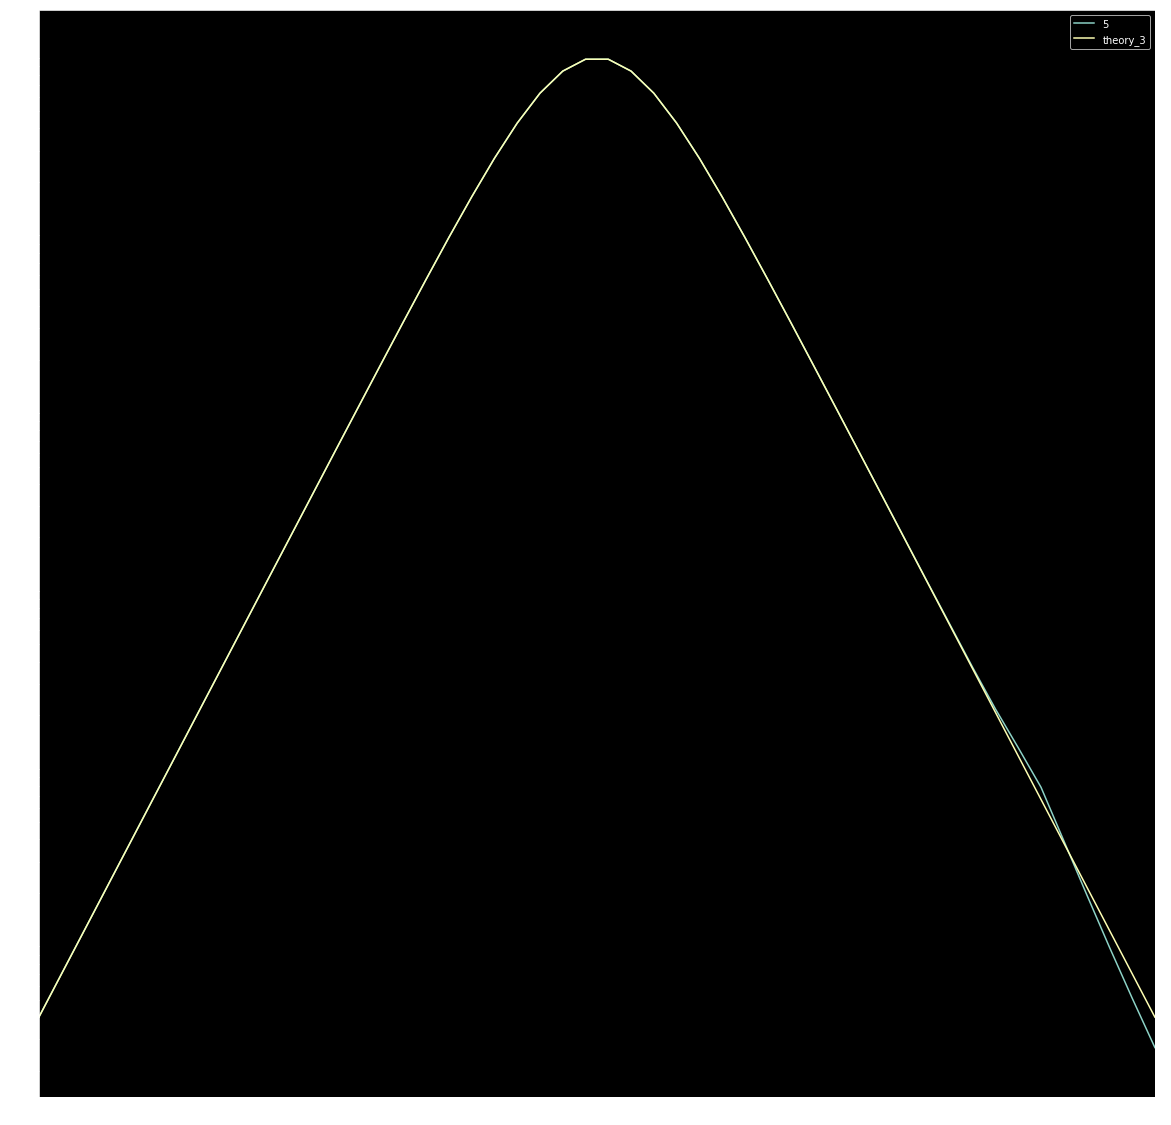

In [15]:
slopes = np.array([100, 10, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.1, 0.075, 0.05, 0.025, 
                   0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005, 0.00025, 0.0001]) #np.linspace(1, 10000, 50)

start,end = np.log10(10**-3), np.log10(10**3)
slopes = 10**np.linspace(start, end, 50)

mod = ILeakyReLU(invert=False)
noisy_rec = torch.cuda.FloatTensor(0)

out_snr = {}
in_snr  = {}
alpha_snr = {}

for ratio in [5]:#1, 2, 3, 4, 5]:    
    out_snr[ratio] = {}
    in_snr[ratio]  = {}
    alpha_snr[ratio] = {}
    for neg_slope in slopes:
        mod.negative_slope=neg_slope
        inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="uniform")-0.5
        noise = (input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="uniform")-0.5)*10**-ratio#.01

        out = mod(inp)
        noisy_out = out + noise
        mod.inverse(noisy_rec, noisy_out.clone())
        
        in_snr[ratio][neg_slope]  = f["snr"]((inp, noisy_rec))
        out_snr[ratio][neg_slope] = f["snr"]((out, noisy_out))
        alpha_snr[ratio][neg_slope] = snr_th(inp, out, noise, noisy_out, neg_slope)#new_alpha(inp, out, noisy_out)
        
df = pd.DataFrame(in_snr) / pd.DataFrame(out_snr)

df["theory_3"]=df.index.map(alpha)
df.plot(logx=True, logy=True, figsize=(20,20))

### Unsuccessful attempts to characterise transition and high noise regimes

In [6]:
def snr_th(inp, out, noise, noisy_out, slope):
    msk_neg = inp<0
    msk_pos = inp>0

    noflip = (out>0)==(noisy_out>0)
    flip   = 1 - noflip

    PP  = (msk_pos+noflip) == 2
    NN  = (msk_neg+noflip) == 2
    NP  = (msk_neg+flip)   == 2
    PN  = (msk_pos+flip)   == 2
    
    s1  = ( out[PP]**2).sum()          # PP
    s4  = ( out[NP]**2).sum()          # NP
    s2  = ((out[PN]/slope)**2).sum()   # PN
    s3  = ((out[NN]/slope)**2).sum()   # NN
    s_2 = s1 + s2 + s3 + s4
    
    e1  = ( noise[PP]**2).sum()
    e4  = ( noise[NP]**2).sum()
    e2  = ((noise[PN]/slope)**2).sum()
    e3  = ((noise[NN]/slope)**2).sum()
    e_2 = e1 + e2 + e3 + e4
    
    return (s_2 / e_2).item()

In [23]:
# Need inp and noisy_out
# Have input? No.

def snr_th(inp, out, noise, noisy_out, slope):
    msk_neg = inp<0
    msk_pos = inp>0
    noflip = (out>0)==(noisy_out>0)
    flip   = 1 - noflip

    PP  = (msk_pos+noflip) == 2
    NN  = (msk_neg+noflip) == 2
    NP  = (msk_neg+flip)   == 2
    PN  = (msk_pos+flip)   == 2
    
    e2  = ((inp[PN] - noisy_rec[PN])**2).sum()
    e3  = ((inp[NN] - noisy_rec[NN])**2).sum()
    e4  = ((inp[NP] - noisy_rec[NP])**2).sum()
    e1  = ((inp[PP] - noisy_rec[PP])**2).sum()

    e = e1 + e2 + e3 + e4
    
    return ((inp**2).sum() / e).item()

In [55]:
ratio = 2
neg_slope = 0.1

inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="uniform")-0.5
noise = (input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="uniform")-0.5)*10**-ratio#.01
mod.negative_slope=neg_slope

out = mod(inp)
noisy_out = out + noise
mod.inverse(noisy_rec, noisy_out.clone())
err = (inp - noisy_rec)

In [56]:
msk_neg = inp<0
msk_pos = inp>0
noflip = (out>0)==(noisy_out>0)
flip   = 1 - noflip

PP  = (msk_pos+noflip) == 2
NN  = (msk_neg+noflip) == 2
NP  = (msk_neg+flip)   == 2
PN  = (msk_pos+flip)   == 2

#e2  = ((inp[PN] - noisy_rec[PN])**2)#.sum()
#e3  = ((inp[NN] - noisy_rec[NN])**2)#.sum()
#e4  = ((inp[NP] - noisy_rec[NP])**2)#.sum()
#e1  = ((inp[PP] - noisy_rec[PP])**2)#.sum()

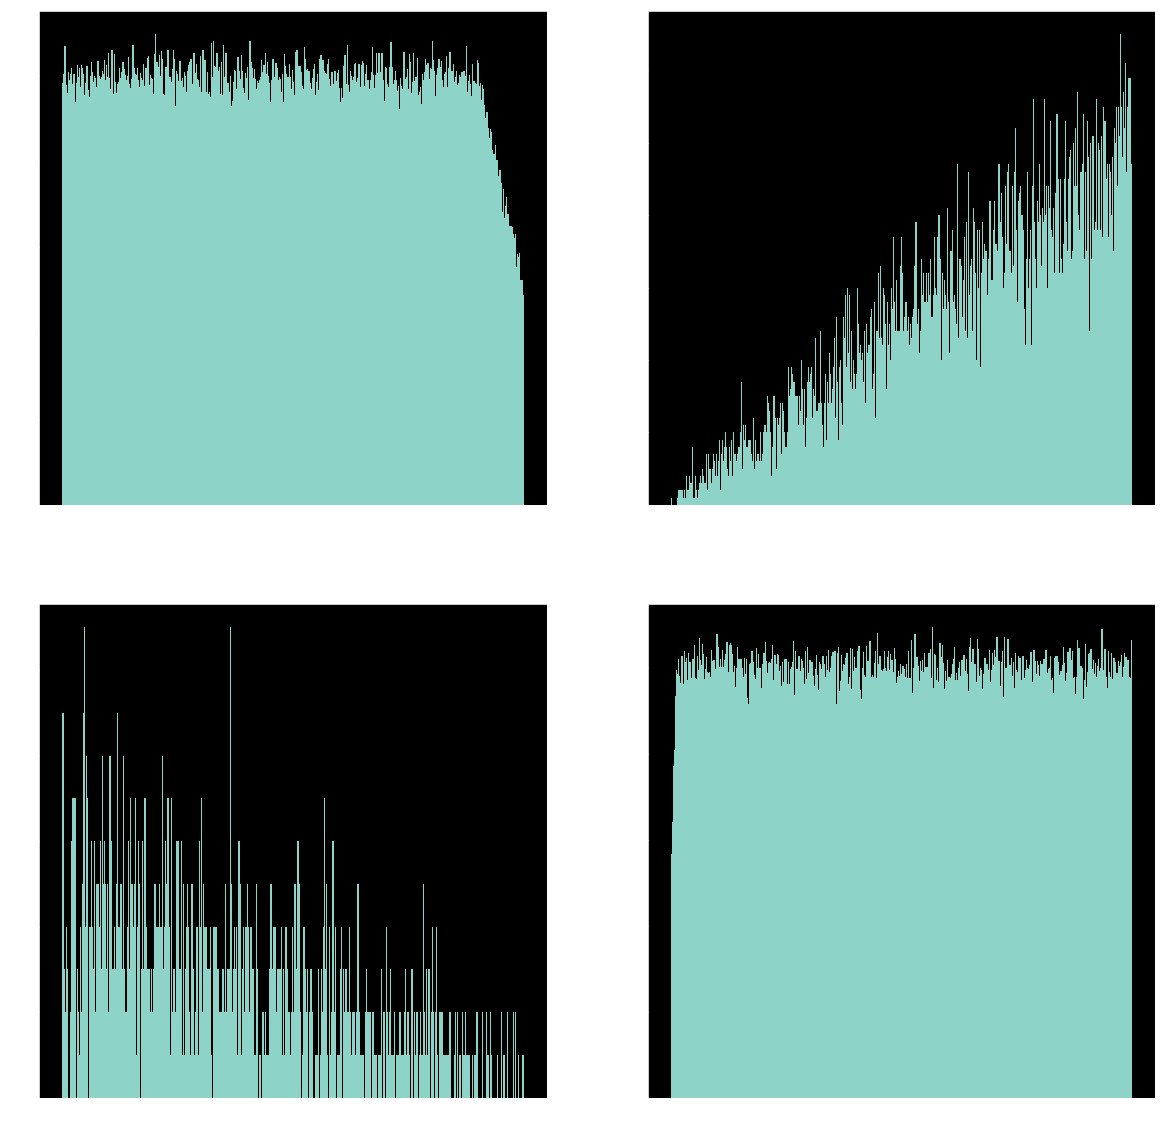

In [57]:
def hist(x, ax, bins=500, logy=False):
    width = x.std().item()/100
    x = x.cpu().numpy().flatten()
    x.sort()
    x,y = np.histogram(x, bins=bins)
    y=y[:-1]
    if logy:
        x=np.log10(x)
    ax.bar(y, x, width=width)
    
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

hist(inp[NN], ax[0,0])
hist(inp[NP], ax[0,1])
hist(inp[PN], ax[1,0])
hist(inp[PP], ax[1,1])

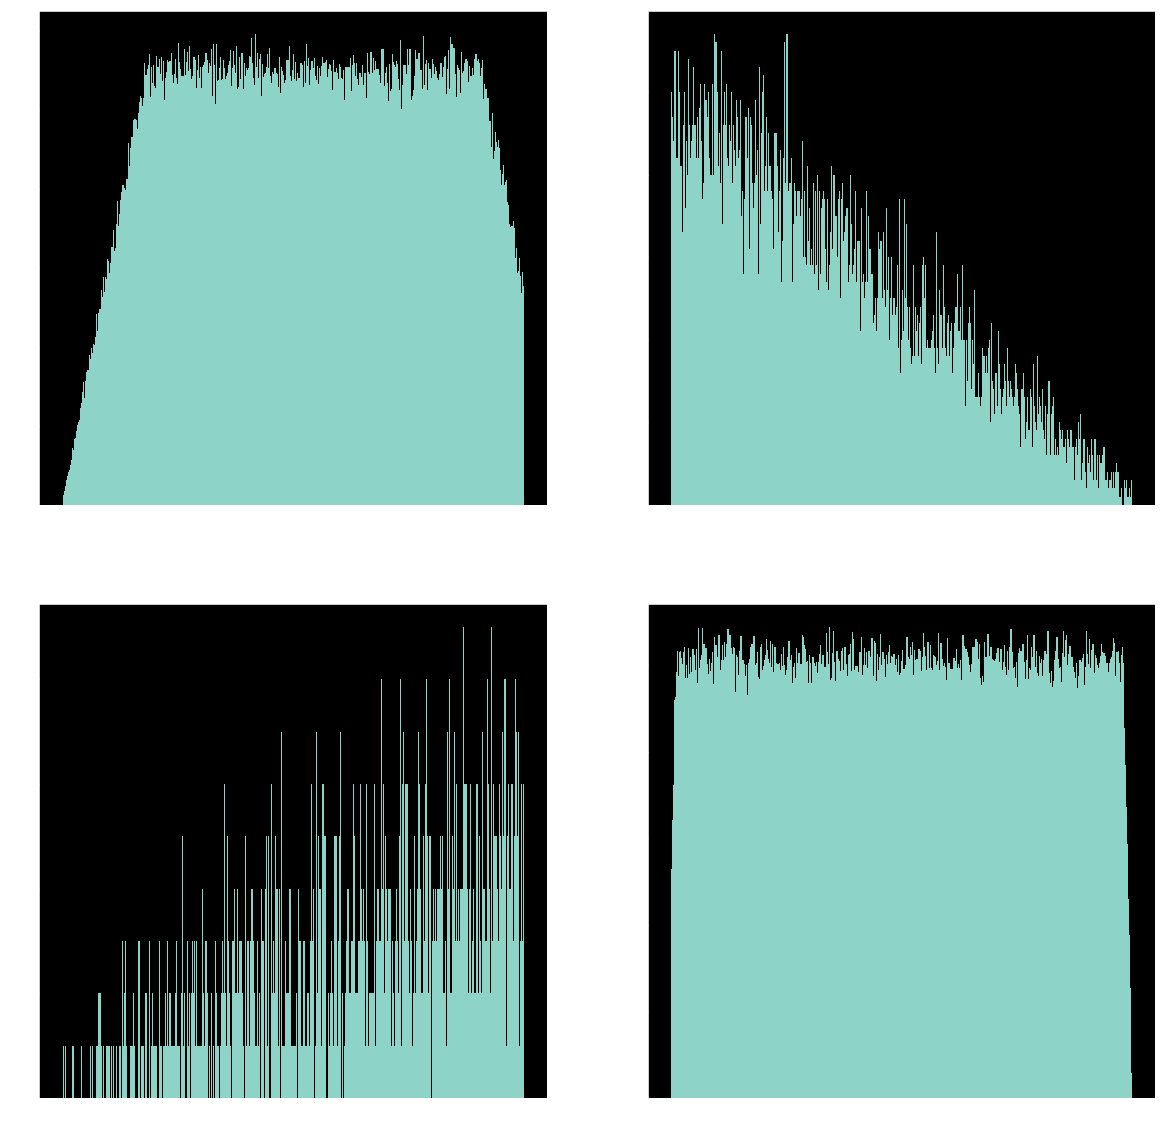

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

hist(noisy_rec[NN], ax[0,0])
hist(noisy_rec[NP], ax[0,1])
hist(noisy_rec[PN], ax[1,0])
hist(noisy_rec[PP], ax[1,1])

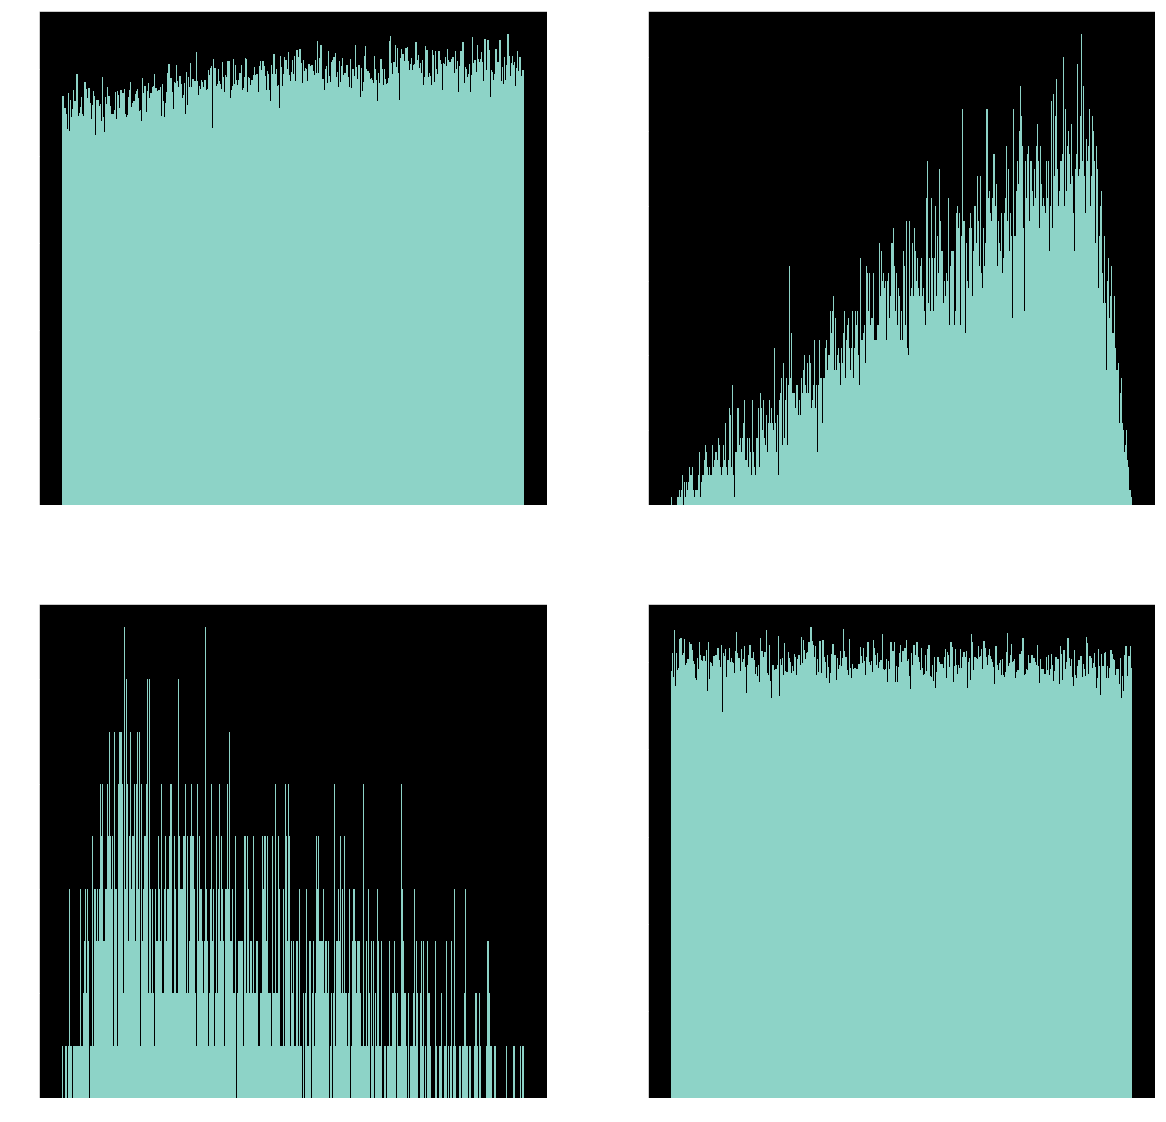

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

hist(err[NN], ax[0,0])
hist(err[NP], ax[0,1])
hist(err[PN], ax[1,0])
hist(err[PP], ax[1,1])

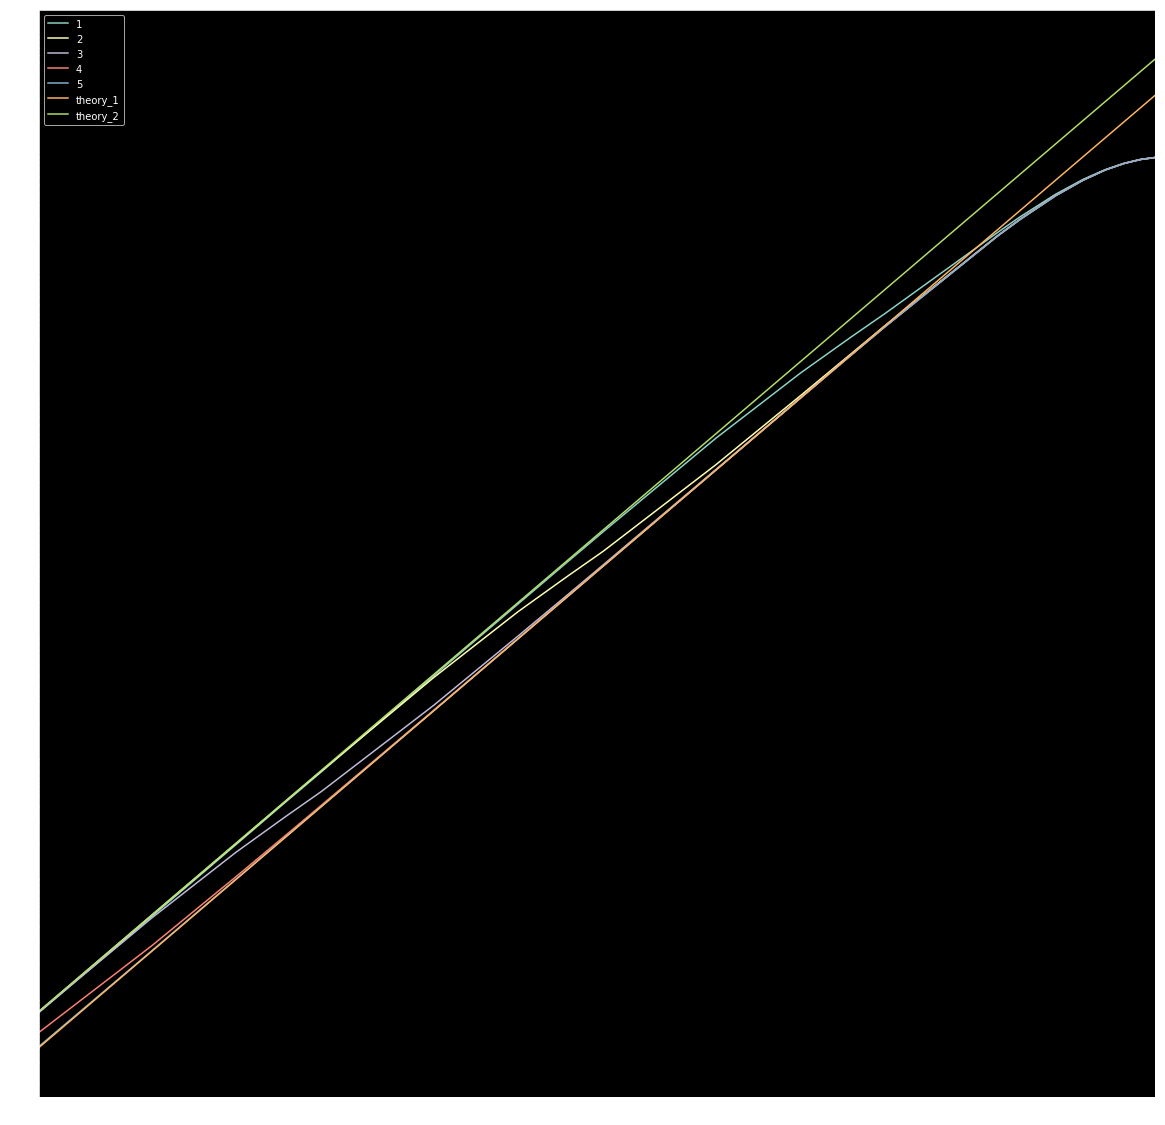

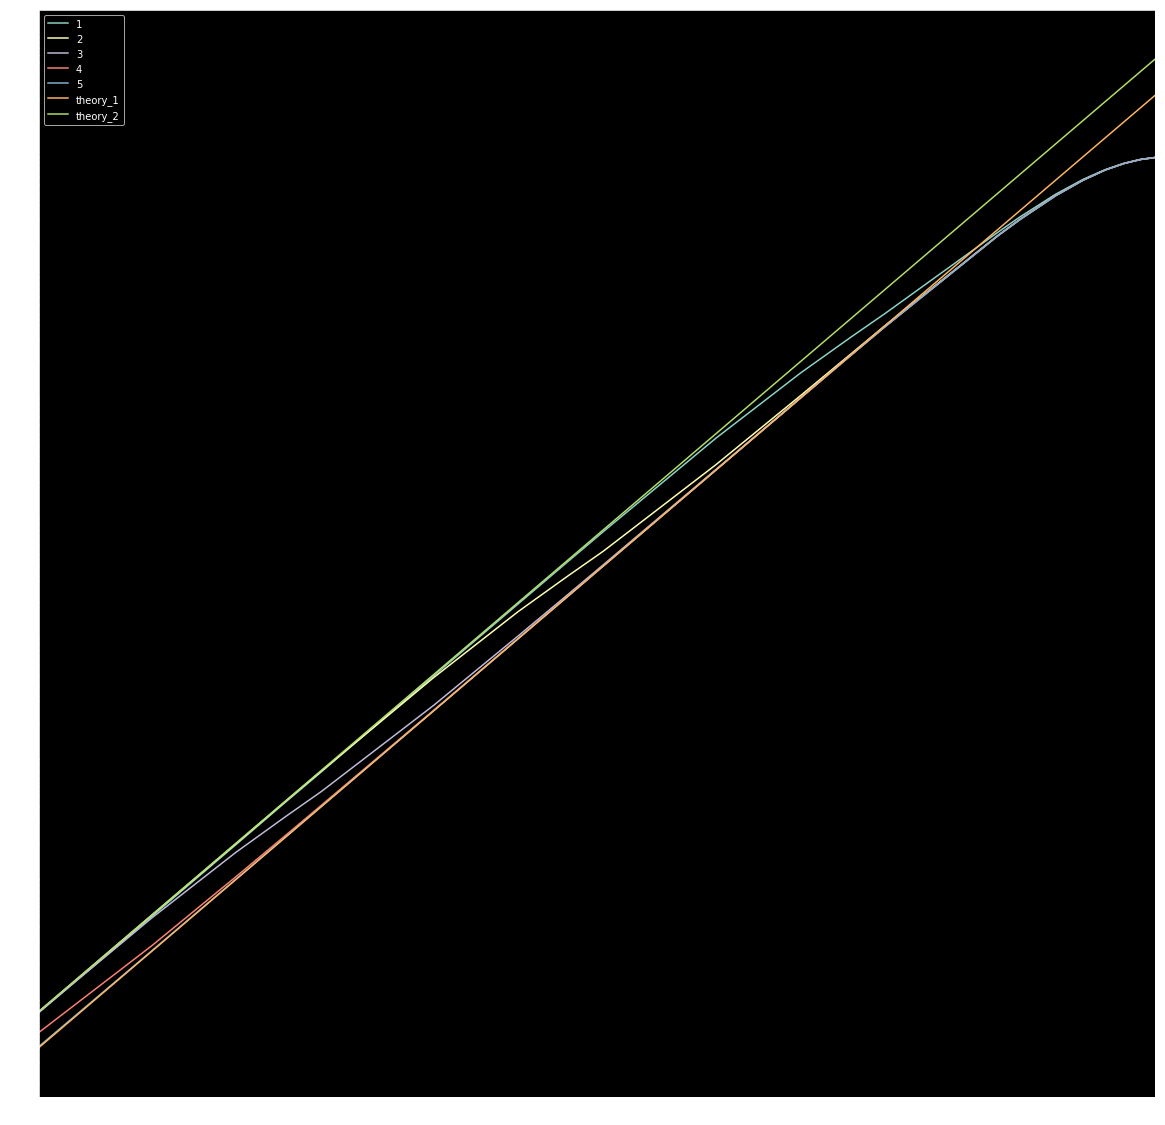

In [18]:
df2 = (pd.DataFrame(alpha_snr) / pd.DataFrame(out_snr))
df2["theory_1"]=df.index.map(lambda x:x**2*4)
df2["theory_2"]=df.index.map(lambda x:x**2*8)

df2.plot(logx=True, logy=True, figsize=(20,20))
df.plot(logx=True, logy=True, figsize=(20,20))

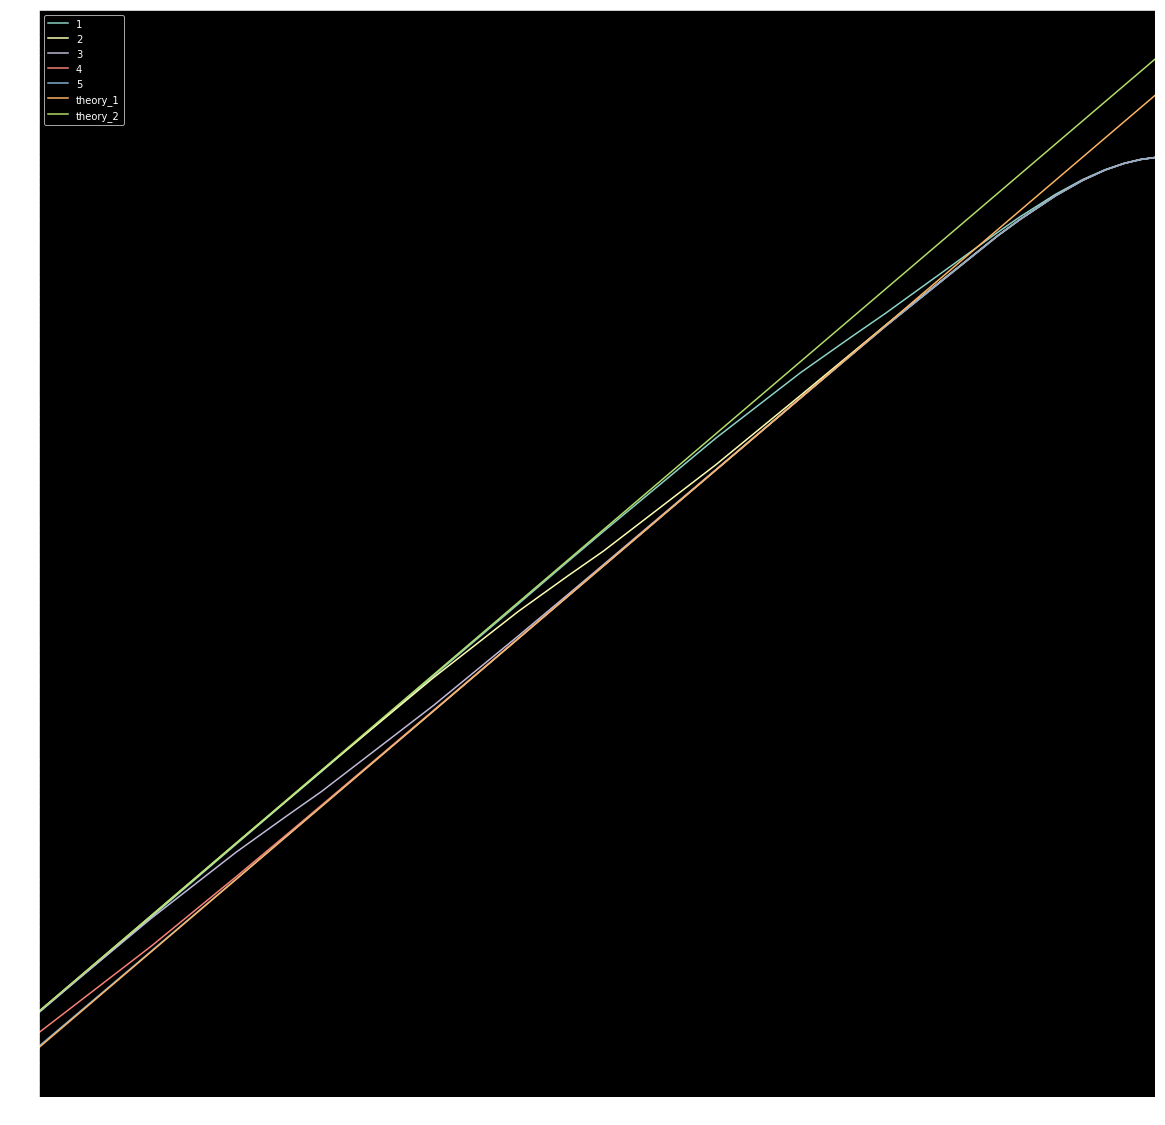

In [8]:
df = pd.DataFrame(alpha_snr) / (pd.DataFrame(out_snr))

df["theory_1"]=df.index.map(lambda x:x**2*4)
df["theory_2"]=df.index.map(lambda x:x**2*8)

df.plot(logx=True, logy=True, figsize=(20,20))

In [71]:
#df

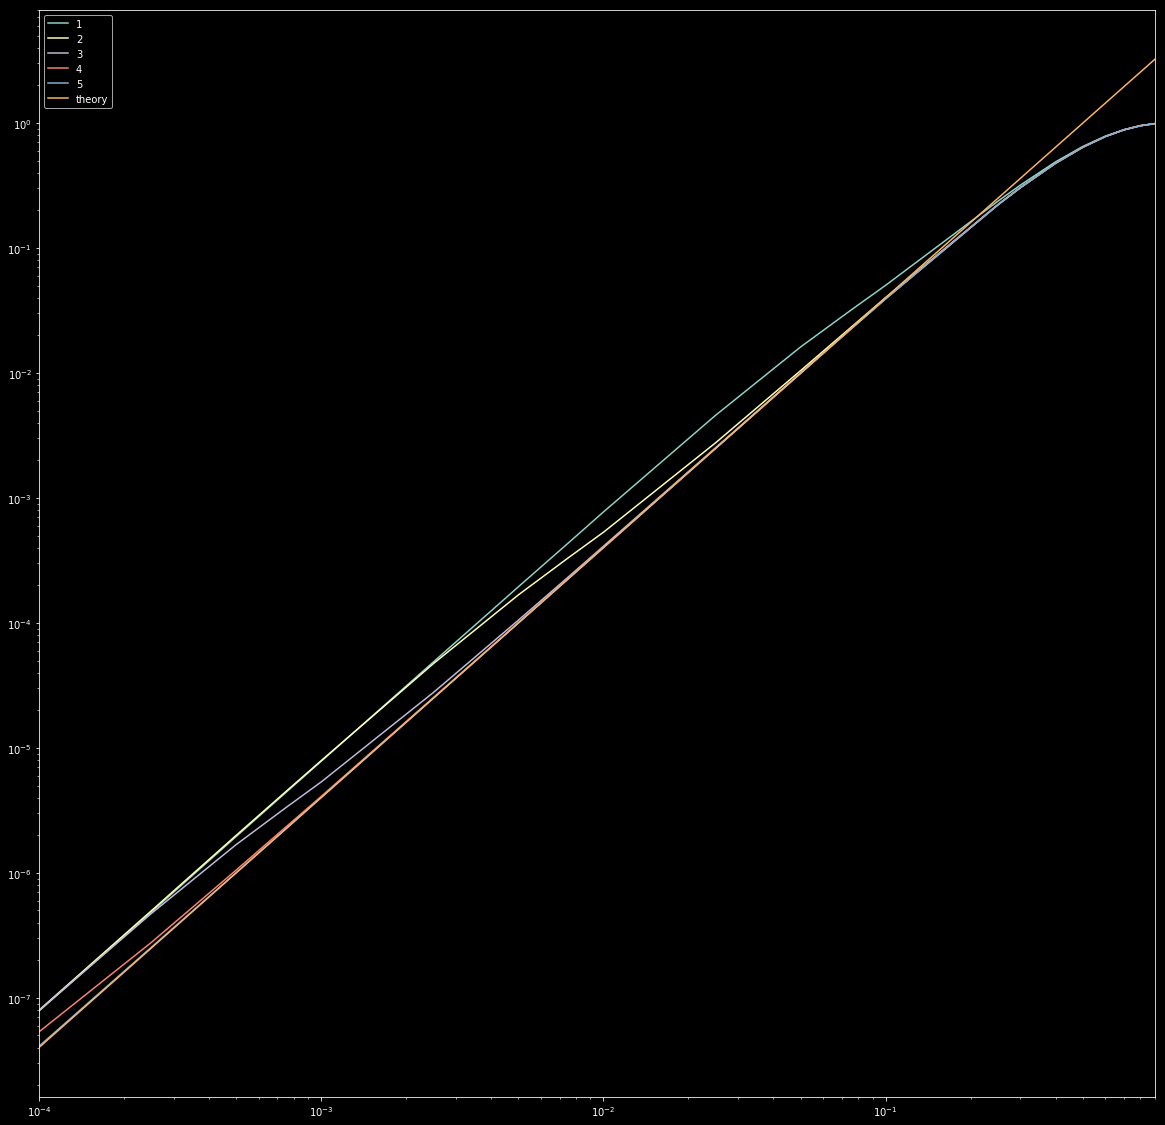

In [28]:
df.plot(logx=True, logy=True, figsize=(20,20))

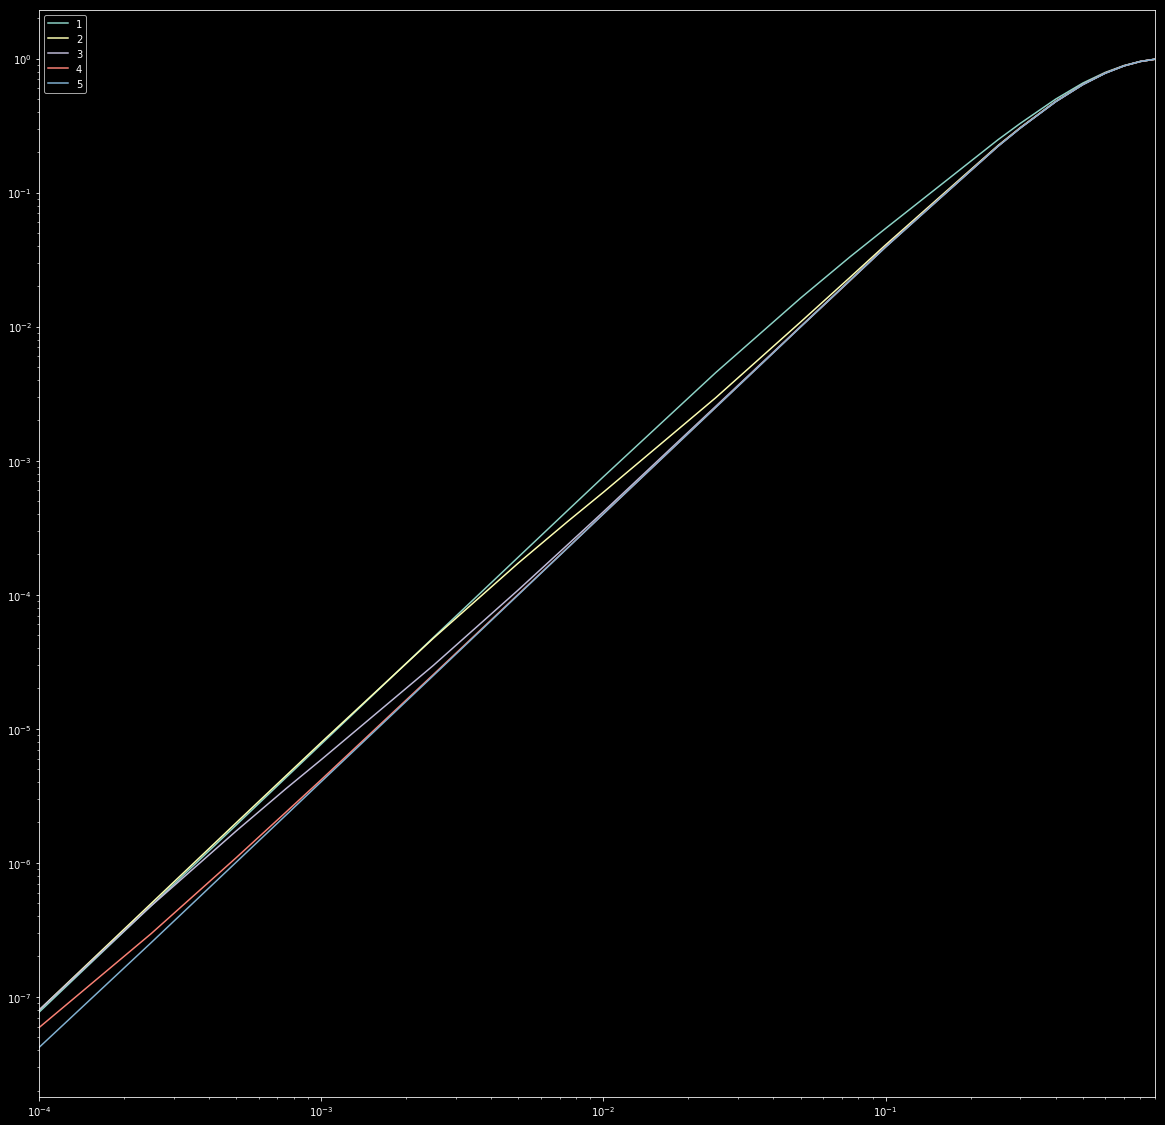

In [20]:
df.plot(logx=True, logy=True, figsize=(20,20))

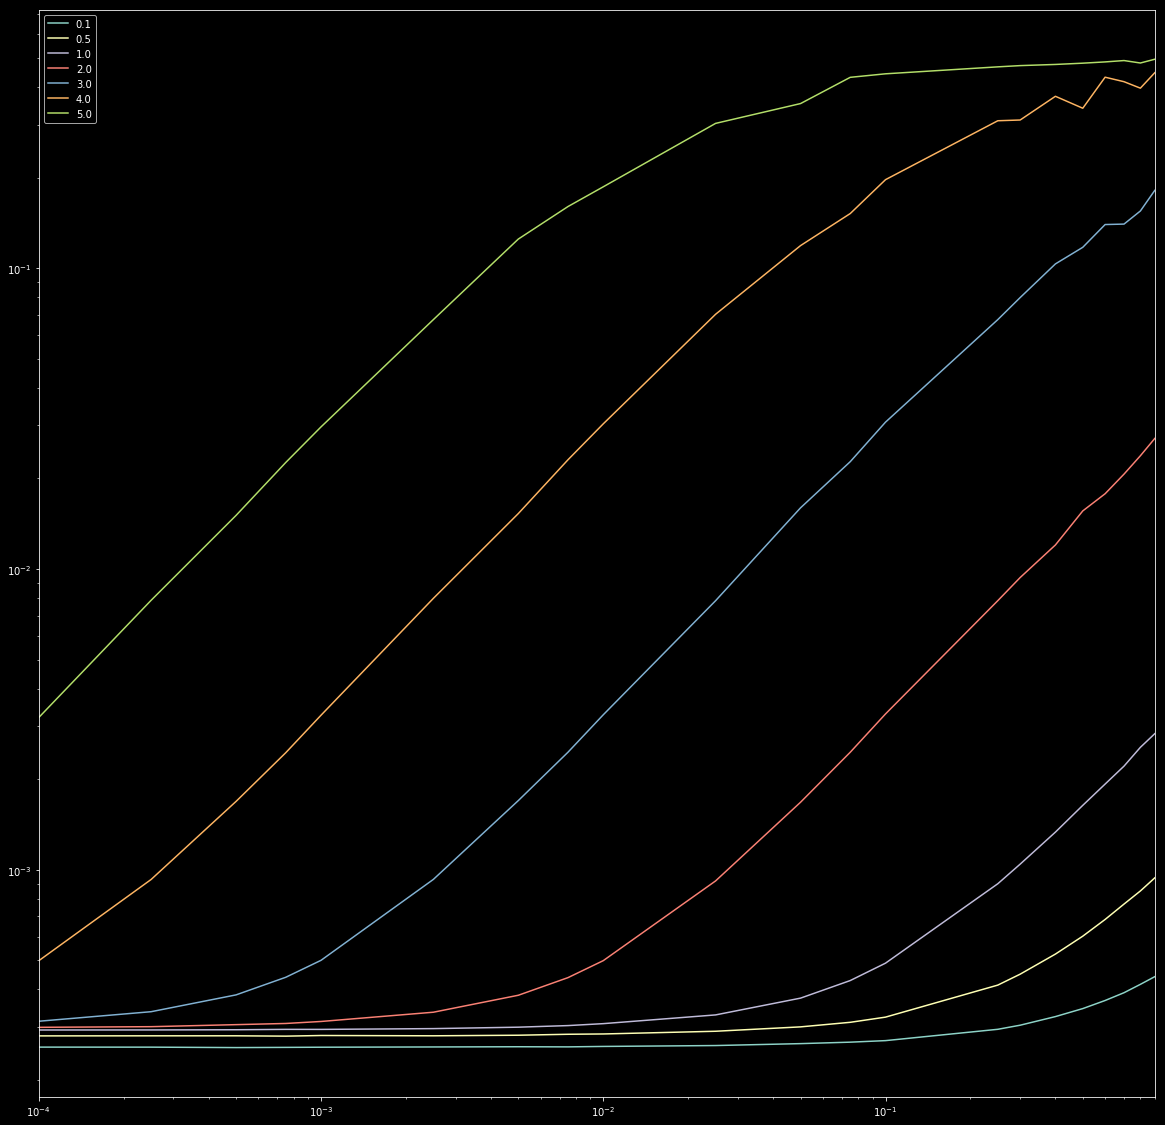

In [9]:
df_st.plot(logx=True, logy=True, figsize=(20,20))

# BN

In [16]:
class IBatchNorm2d(nn.BatchNorm2d):
    """
    """
    def __init__(self, *args, ieps=0, invert=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.ieps = ieps
        self.set_invert(invert)
        
    def set_invert(self, invert):
        self.invert = invert
        
    def forward(self, x):
        if self.invert:
            return self.i_forward(x)
        else:
            return super().forward(x)

    def i_forward(self, x):
        with torch.no_grad():
            x_ = x.permute(1,0,2,3).contiguous().view(x.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = F.batch_norm( 
            x, None, None, self.weight.abs() + self.ieps, self.bias, 
            True, 0.0, self.eps
        )

        if self.training and out.requires_grad:
            handle_ref = [0]
            handle_ref_ = out.register_hook(self.get_variable_backward_hook(x, out, std, mean, handle_ref))
            handle_ref[0] = handle_ref_
        x.data.set_()
        return out
        
    def inverse(self, y, x, std, mean):
        with torch.no_grad():
#             x_ =  F.batch_norm(
#                         y, None, None, std, mean, 
#                         True, 0.0, 0
#                     )
            
            mean = mean[None,:,None,None]
            var = (std**2)[None,:,None,None]
            bias = self.bias[None,:,None,None]
            weight = self.weight[None,:,None,None]

            x_ = (y-bias)/(weight.abs()+self.ieps) * (var+self.eps).sqrt() + mean
        x.data.set_(x_)
        y.data.set_()

    def get_variable_backward_hook(self, x, output, std, mean, handle_ref):
        def backward_hook(grad):
            self.inverse(output, x, std, mean)
            handle_ref[0].remove()
        return backward_hook

In [17]:
def init_bn_weight(mod, fact=1, nch=1):
    weight = mod.weight.data
    ww = torch.ones_like(weight)
    perm = torch.randperm(100)
    ww[perm<=nch] = ww[perm<=nch]/fact
    weight.set_(ww)

facts = np.linspace(1, 100, 50)
mod   = IBatchNorm2d(ch, invert=False, ieps=0, eps=0).cuda()
noisy_rec = torch.cuda.FloatTensor(0)

out_snr = {}
in_snr  = {}

for ratio in [1, 2, 3, 4]:#, 5, 6]:
    out_snr[ratio] = {}
    in_snr[ratio]  = {}
    for fact in facts:
        init_bn_weight(mod, fact, nch=ch//5)
        inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="normal")
        noise = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0., sigma=1*10**-ratio, dist="normal")#.01
        
        with torch.no_grad():
            x_ = inp.permute(1,0,2,3).contiguous().view(inp.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = mod(inp)
        noisy_out = out + noise
        mod.inverse(noisy_out.clone(), noisy_rec, std, mean)
        
        in_snr[ratio][fact]  = f["snr"]((inp, noisy_rec))
        out_snr[ratio][fact] = f["snr"]((out, noisy_out))
        
df = pd.DataFrame(in_snr) / pd.DataFrame(out_snr)
df.index=facts

In [11]:
# Alpha for two parameters
alpha_ = lambda phi, rho_p, rho_n: ( (rho_p + rho_n*(phi**2)) * (rho_p + rho_n/(phi**2)) )**-1

# Alpha for arbitrary bn layer
def alpha_gen(w):
    ww = w.cpu().numpy().flatten()
    ww_sq = ww**2
    nb_ch = ww.size
    alpha = ( ( np.sum(ww_sq)/nb_ch ) * ( np.sum(1/ww_sq)/nb_ch ) )**-1
    return alpha


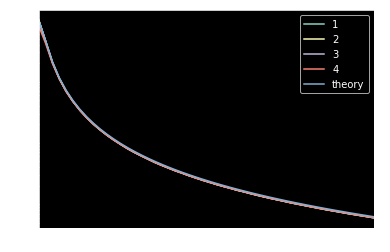

In [12]:
df["theory"]=pd.Series([alpha_((1/s), 0.2, 0.8) for s in facts], index=facts)#.plot(logy=True)
df.plot(logy=True)

In [13]:
#pd.Series([alpha_((1/s), 0.2, 0.8) for s in facts])

In [47]:
def init_bn_weight(mod, fact=1, nch=1):
    weight = mod.weight.data
    ww = torch.ones_like(weight)
    perm = torch.randperm(100)
    ww[perm<=nch] = ww[perm<=nch]/fact
    weight.set_(ww)

facts = np.linspace(0, 10, 50)
noisy_rec = torch.cuda.FloatTensor(0)

out_snr = {}
in_snr  = {}
theory = {}
for ratio in [1, 2, 3, 4]:#, 5, 6]:
    out_snr[ratio] = {}
    in_snr[ratio]  = {}
    theory[ratio]  = {}
    for ieps in facts:
        mod   = IBatchNorm2d(ch, invert=False, ieps=0, eps=0).cuda()
        
#         init_bn_weight(mod, fact, nch=ch//5)
#         mod.ieps = ieps
        inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="normal")
        noise = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0., sigma=1*10**-ratio, dist="normal")#.01
        
        with torch.no_grad():
            x_ = inp.permute(1,0,2,3).contiguous().view(inp.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = mod(inp)
        noisy_out = out + noise
        mod.inverse(noisy_out.clone(), noisy_rec, std, mean)
        
        in_snr[ratio][ieps]  = f["snr"]((inp, noisy_rec))
        out_snr[ratio][ieps] = f["snr"]((out, noisy_out))
        theory[ratio][ieps] = alpha_gen( mod.weight.data )

df = pd.DataFrame(in_snr) / pd.DataFrame(out_snr)
df.index=facts

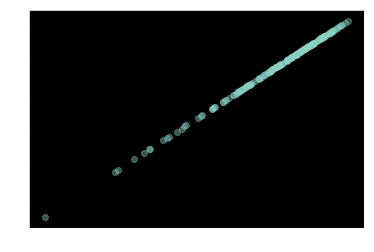

In [52]:
x = [th for th_ in theory.values()
for th in th_.values()]

y = [isnr/osnr for isnr_,osnr_ in zip(in_snr.values(), out_snr.values())
for isnr,osnr in zip(isnr_.values(), osnr_.values())]

plt.scatter(np.log10(x), np.log10(y), alpha=.4)